In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
openc

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
import os
import time
import pickle
from gensim.models import KeyedVectors

# For data splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# For Keras model building
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout # Import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- 1. Copy the FastText file from Drive to the local Colab machine ---
drive_path = "/content/drive/MyDrive/Depression detection dataset/wiki-news-300d-1M-subword.vec.zip"
colab_zip_path = "/content/wiki-news-300d-1M-subword.vec.zip"

print(f"Copying file from your Google Drive...")
!cp "{drive_path}" "/content/"

# --- 2. Unzip the file ---
print(f"\nCopy complete. Unzipping the file...")
# The -n flag prevents overwriting if the file already exists from a previous run.
!unzip -n "{colab_zip_path}"

print("\nSetup complete. FastText .vec file is now ready in the Colab environment.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying file from your Google Drive...

Copy complete. Unzipping the file...
Archive:  /content/wiki-news-300d-1M-subword.vec.zip
  inflating: wiki-news-300d-1M-subword.vec  

Setup complete. FastText .vec file is now ready in the Colab environment.


In [ ]:
# --- Load the FastText vectors into a Gensim model ---

# Define the path to the unzipped .vec file
fasttext_vec_path = 'wiki-news-300d-1M-subword.vec'

print(f"Loading word vectors from '{fasttext_vec_path}' into memory...")
print("This is a large file and will take a few minutes to load.")

# Use Gensim's KeyedVectors to load the pre-trained model
ft_model = KeyedVectors.load_word2vec_format(fasttext_vec_path)

print("\nFastText vectors loaded successfully.")

Loading word vectors from 'wiki-news-300d-1M-subword.vec' into memory...
This is a large file and will take a few minutes to load.

FastText vectors loaded successfully.


In [ ]:
# --- 1. Load your dataset ---
file_path = '/content/drive/MyDrive/Depression detection dataset/BSMDD_main.xlsx'
df = pd.read_excel(file_path)

# Drop any rows where the text is missing and reset the index
df.dropna(subset=['text_banglish'], inplace=True)
df.reset_index(drop=True, inplace=True)


# --- 2. Define the preprocessing function ---
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# --- 3. Apply the function to create a 'cleaned_text' column ---
df['cleaned_text'] = df['text_banglish'].apply(preprocess_text)

# --- 4. Safeguard: Remove any empty rows ---
original_rows = len(df)
df = df[df['cleaned_text'] != ''].reset_index(drop=True)
if original_rows > len(df):
    print(f"Removed {original_rows - len(df)} rows that were empty after preprocessing.")

# --- 5. Display the result to verify ---
print("DataFrame after preprocessing:")
print(df[['text_banglish', 'cleaned_text', 'label']].head())

Removed 2 rows that were empty after preprocessing.
DataFrame after preprocessing:
                                       text_banglish  \
0  manasika sharirikabhabe asustha klanta puro ji...   
1  daya sathe thakuna atyanta dirgha apanake pada...   
2  janatama sathe bhula loka kharapa jibana katiy...   
3  anetibha imreji spikarera anusarana biraktikar...   
4  anetibha imreji spikarera anusarana biraktikar...   

                                        cleaned_text  label  
0  manasika sharirikabhabe asustha klanta puro ji...      1  
1  daya sathe thakuna atyanta dirgha apanake pada...      1  
2  janatama sathe bhula loka kharapa jibana katiy...      1  
3  anetibha imreji spikarera anusarana biraktikar...      1  
4  anetibha imreji spikarera anusarana biraktikar...      1  


In [ ]:
# --- 1. Tokenize text and pad sequences ---
texts = df['cleaned_text'].tolist()
labels = df['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

lengths = [len(s) for s in sequences]
maxlen = int(np.percentile(lengths, 95))
X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
y = labels
print(f"Found {len(word_index)} unique tokens. Padded sequences to length {maxlen}.")


# --- 2. Create the embedding matrix from the FastText model ---
embedding_dim = 300  # Must match the FastText model's dimensions (300d)
hits = 0
misses = 0
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in ft_model:
        embedding_matrix[i] = ft_model[word]
        hits += 1
    else:
        misses += 1

print(f"\nEmbedding Matrix Shape: {embedding_matrix.shape}")
print(f"Found {hits} words ({misses} misses) in the FastText vocabulary.")
# The coverage percentage is a great metric for your paper.
print(f"Vocabulary Coverage: {100 * hits / (hits + misses):.2f}%")


# --- 3. Split data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

print(f"\nTraining data shape (X_train): {X_train.shape}")
print(f"Testing data shape (X_test): {X_test.shape}")

Found 56826 unique tokens. Padded sequences to length 192.

Embedding Matrix Shape: (56827, 300)
Found 2382 words (54444 misses) in the FastText vocabulary.
Vocabulary Coverage: 4.19%

Training data shape (X_train): (17526, 192)
Testing data shape (X_test): (4382, 192)


In [ ]:
# --- 1. Build the LSTM Model ---

model = Sequential()

# 1. Embedding Layer
# We load our FastText-based embedding matrix.
# The output_dim must be 300 to match the vectors.
model.add(Embedding(input_dim=vocab_size,
                    output_dim=300, # This is 300 for our FastText model
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))

# 2. LSTM Layer
model.add(LSTM(units=64))

# 3. Dropout for regularization
model.add(Dropout(0.3))

# 4. A standard Dense layer
model.add(Dense(32, activation='relu'))

# 5. Final Output Layer for binary classification
model.add(Dense(1, activation='sigmoid'))


# --- 2. Compile the Model ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# --- 3. Print Model Summary ---
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    17,048,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,048,100 (65.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,048,100 (65.03 MB)

In [ ]:
# --- Train the Model ---

print("Starting LSTM model training with FastText embeddings...")

# Use EarlyStopping to prevent overfitting and save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define number of epochs and batch size
epochs = 20
batch_size = 32

# Start the timer
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Stop the timer
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"\nTraining finished in {training_time:.2f} seconds (approx {training_time/60:.1f} minutes).")

Starting LSTM model training with FastText embeddings...
Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 107s 189ms/step - accuracy: 0.5047 - loss: 0.6930 - precision: 0.5051 - recall: 0.6646 - val_accuracy: 0.5002 - val_loss: 0.6929 - val_precision: 0.5002 - val_recall: 1.0000
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 105s 192ms/step - accuracy: 0.5076 - loss: 0.6927 - precision: 0.5119 - recall: 0.4668 - val_accuracy: 0.5087 - val_loss: 0.6925 - val_precision: 0.6364 - val_recall: 0.0415
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 100s 183ms/step - accuracy: 0.4955 - loss: 0.6927 - precision: 0.4911 - recall: 0.4663 - val_accuracy: 0.5094 - val_loss: 0.6924 - val_precision: 0.6280 - val_recall: 0.0470
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 101s 184ms/step - accuracy: 0.5097 - loss: 0.6920 - precision: 0.5354 - recall: 0.2404 - val_accuracy: 0.5078 - val_loss: 0.6925 - val_precision: 0.6224 - val_recall: 0.0406
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 97s 177ms/step - accuracy: 0.5111 - loss: 0.691

--- Final Performance Evaluation (LSTM with FastText) ---
137/137 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step

Overall Test Metrics:
Accuracy:  0.5094
F1 Score:  0.0874
ROC-AUC Score: 0.5026

Classification Report:
                   precision    recall  f1-score   support

Not Depressed (0)       0.50      0.97      0.66      2190
    Depressed (1)       0.63      0.05      0.09      2192

         accuracy                           0.51      4382
        macro avg       0.57      0.51      0.38      4382
     weighted avg       0.57      0.51      0.38      4382


Confusion Matrix:


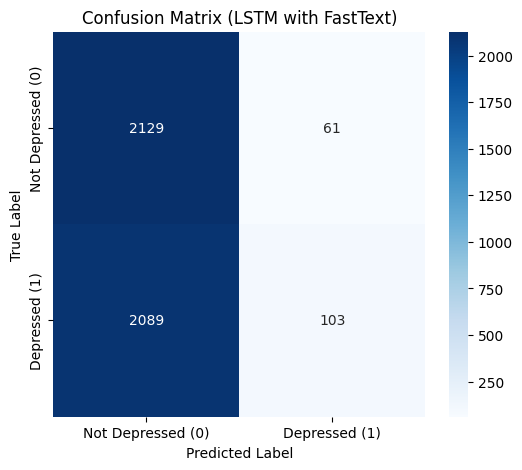



--- Time Complexity ---
Total Training Time: 657.61 seconds (approx. 11.0 minutes)
137/137 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step
Total Inference Time for 4382 samples: 11.9603 seconds
Average Inference Time per Sample: 2.7294 milliseconds


--- Space Complexity ---
Total Model Parameters: 17,143,653
Model Size on Disk: 66.16 MB


In [ ]:
# --- 1. Performance Evaluation on Test Set ---
print("--- Final Performance Evaluation (LSTM with FastText) ---")

# Get model's prediction probabilities on the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary class labels (0 or 1) using a 0.5 threshold
y_pred = (y_pred_probs > 0.5).astype("int32")

# Calculate and print the final metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs) # Use probabilities for ROC-AUC

print(f"\nOverall Test Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}\n")

# Display a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Depressed (0)', 'Depressed (1)']))


# --- 2. Display the Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Depressed (0)', 'Depressed (1)'],
            yticklabels=['Not Depressed (0)', 'Depressed (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (LSTM with FastText)')
plt.show()
print("\n" + "="*50 + "\n")


# --- 3. Practical Time Complexity Analysis ---
print("--- Time Complexity ---")
print(f"Total Training Time: {training_time:.2f} seconds (approx. {training_time/60:.1f} minutes)")

# Measure Inference Time
inference_start_time = time.time()
_ = model.predict(X_test)
inference_end_time = time.time()
total_inference_time = inference_end_time - inference_start_time
avg_inference_time_per_sample = total_inference_time / len(X_test)

print(f"Total Inference Time for {len(X_test)} samples: {total_inference_time:.4f} seconds")
print(f"Average Inference Time per Sample: {avg_inference_time_per_sample * 1000:.4f} milliseconds\n")
print("="*50 + "\n")


# --- 4. Practical Space Complexity Analysis ---
print("--- Space Complexity ---")
total_params = model.count_params()
print(f"Total Model Parameters: {total_params:,}")

# Save the model with a unique name
model_filename = "depression_detection_lstm_fasttext.keras"
model.save(model_filename)
model_size_bytes = os.path.getsize(model_filename)
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"Model Size on Disk: {model_size_mb:.2f} MB")

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 192, 300)       │    17,048,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,334,761 (66.13 MB)

 Trainable params: 95,553 (373.25 KB)

 Non-trainable params: 17,048,100 (65.03 MB)

 Optimizer params: 191,108 (746.52 KB)

In [ ]:
import os
import pickle

# --- 1. Save the Tokenizer to a file in the Colab environment ---
tokenizer_filename = 'tokenizer_lstm_fasttext.pickle'
with open(tokenizer_filename, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Keras Tokenizer saved to '{tokenizer_filename}'")


# --- 2. Copy the model artifacts to your Google Drive ---
# Define the destination folder in your Google Drive
destination_folder = '/content/drive/MyDrive/Depression detection dataset/saved_models/LSTM_FastText/'

# Create the folder if it doesn't already exist
os.makedirs(destination_folder, exist_ok=True)

# List of all the files we want to save from this experiment
files_to_copy = [
    'depression_detection_lstm_fasttext.keras', # Saved in the evaluation step
    'tokenizer_lstm_fasttext.pickle'            # Just saved now
]

# Loop through the files and copy them to your Drive
for filename in files_to_copy:
  source_path = f'./{filename}'
  destination_path = os.path.join(destination_folder, filename)
  if os.path.exists(source_path):
    !cp "{source_path}" "{destination_path}"
    print(f"Successfully copied '{filename}' to your Google Drive.")
  else:
    print(f"Warning: '{filename}' not found. Please ensure the previous cells were run.")

print(f"\nYour LSTM with FastText model files are now safely stored in your Google Drive!")

Keras Tokenizer saved to 'tokenizer_lstm_fasttext.pickle'
Successfully copied 'depression_detection_lstm_fasttext.keras' to your Google Drive.
Successfully copied 'tokenizer_lstm_fasttext.pickle' to your Google Drive.

Your LSTM with FastText model files are now safely stored in your Google Drive!
